# 3D Segmentation of Brain Tumor

This document is to test the methodology and refine it for execution in FYP B.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

In [48]:
from monai.data import Dataset, CacheDataset,PersistentDataset
from glob import glob
from os import path, listdir
import pytorch_lightning as pl
from sklearn.model_selection import ShuffleSplit

from monai.transforms import (
    LoadImaged,
    SpatialPadd,
    EnsureChannelFirstd,
    Compose,
    NormalizeIntensityd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    MapTransform,
    CropForegroundd,
)

from monai.data import partition_dataset
from monai.networks.nets import UNet,UNETR, SegResNet
from monai.losses import TverskyLoss, DiceLoss
from monai.metrics import DiceMetric
import torch
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
%pip install monai==0.9.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
base_path = r"Datasets\2020\MICCAI_BraTS2020_TrainingData"
# Base Path to the training Dataset

As there are 3 Main Classes to be identified:
1. Non-Enhancing, $c_1$
2. Edema, $c_2$
3. [`Skipped`]
4. Enhancing $c_3$
5. No Tumor, Normal Tissue, $c_{none}$

One-Hot Encoding is done on the segmented dataset to bring each Data point in the segmentation mask into an array similar to
$$
 \overbrace{(c_1 | c_2 | c_3 | c_{none})}^{\text{A Segmented voxel}} \rightarrow  \begin{bmatrix}c_1\\c_2\\c_3\end{bmatrix} 
$$

where each point will correspond to a a class mentioned above. If all elements within the array are 0, then it means that the point is not classified as a malignancy (no tumor).

In [4]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks. Moving 4 to 3.
class ConvertLabelsIntoOneHotd(MapTransform):
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                data_dict[key] == 1,  # Non Enhancing Tumor Core
                data_dict[key] == 2,  # Edema Core
                data_dict[key] == 4,  # Enhancing Tumor Core
            ]
            data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
        return data_dict


In [54]:
cases = [path.join(base_path, x) for x in listdir(base_path)]
# Appends all cases to a list

mri_images = [
    {
        "image": [
            path.join(case, f"{path.split(case)[-1]}_t1ce.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_t2.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_flair.nii.gz"),
        ],
        "seg": path.join(case, f"{path.split(case)[-1]}_seg.nii.gz"),
    }
    for case in cases[:100]  #! Only 100 cases taken as test slice
]
# Extract the path to the training nifti files of each case. Chosen are t1ce, t2 and flair. Segmentation is also extracted.

training_data, validation_data = partition_dataset(mri_images, ratios=[0.7,0.3],shuffle=True)
# 70 - 30 split of the training data.


# TODO: Research more about the following transforms as well as importance of transforms for MRI data.
transform_images_train = Compose(
    [
        LoadImaged(keys=["image", "seg"]),  # Loads the images and segmentation
        EnsureChannelFirstd(
            keys=["image"]
        ),  # Ensures that the images are in the correct format, ie channel is first dimension.
        ConvertLabelsIntoOneHotd(
            keys=["seg"]
        ),  # Converts the segmentation into one hot encoding
        RandSpatialCropd(keys=["image", "seg"], roi_size=[224, 224, 144], random_size=False),
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),  # Normalise Intensity of the images
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),  # Ensure spacing of voxels are uniform among scans
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        RandFlipd(
            keys=["image", "seg"], prob=0.5, spatial_axis=2
        ),  # Three Random flips along the three axes
    ]
)
# Defines the transformations to be applied to the training data.

transform_images_validation = Compose(
    [
        LoadImaged(keys=["image", "seg"]),  # Loads the images and segmentation
        EnsureChannelFirstd(
            keys=["image"]
        ),  # Ensures that the images are in the correct format, ie channel is first dimension.
        ConvertLabelsIntoOneHotd(
            keys=["seg"]
        ),  # Converts the segmentation into one hot encoding
        RandSpatialCropd(keys=["image", "seg"], roi_size=[224, 224, 144], random_size=False),
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),  # Normalise Intensity of the images
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),  # Ensure spacing of voxels are uniform among scans
    ]
)
# Defines the transformations to be applied to the testing data.


persistent_dataset_path = (
    r"./cache"  # Path of the persistent dataset cache, to speed up training process
)

dataset_training = Dataset(
    training_data, transform=transform_images_train
)  # Preparation of the training dataset <- Testing and debugging

dataset_validation = Dataset(
    validation_data, transform=transform_images_validation
)  # Preparation of the validation dataset <- Testing and debugging

# dataset_training = PersistentDataset(
#     mri_images, transform=transform_images_train, cache_dir=persistent_dataset_path
# )  # Preparation of the training dataset


In [62]:
144/32


4.5

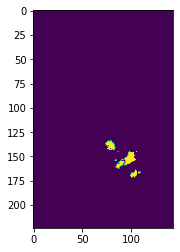

In [61]:
plt.imshow(dataset_training[0]['seg'][0][:,100,:])

In [67]:
# Defining a Basic UNet to Learn and test with limited Dataset
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(
            spatial_dims=3,
            in_channels=3,
            out_channels=3,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
        )

        self.batch_size = 2  #! Adjust with tuning Later
        self.num_workers = 4  #! Change for Machine / Temporarily omitted
        self.learning_rate = 1e-4  #! Adjust with tuning Later

        self.loss_function = DiceLoss(to_onehot_y=False, softmax=True)
        self.dice_metric = DiceMetric(include_background=False, reduction="mean")

    def forward(self, x):
        return self.model(x)

    def prepare_data(self):
        # Make the Datasets based on the sequence of data. To be passed into Data Loaders later.
        self.train_ds = PersistentDataset(
            training_data, transform=transform_images_train, cache_dir="./cache"
        )  # Preparation of the training dataset <- Testing and debugging

        self.val_ds = PersistentDataset(
            validation_data, transform=transform_images_validation, cache_dir="./cache"
        )  # Preparation of the validation dataset <- Testing and debugging

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.batch_size,
        )

    # def val_dataloader(self):
    #     return torch.utils.data.DataLoader(
    #         self.val_ds,
    #         shuffle=True,
    #         batch_size=self.batch_size,
    #         num_workers=self.num_workers,
    #     )

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        image, seg = batch["image"], batch["seg"]
        output = self.forward(image)
        loss = self.loss_function(output, seg)
        return {"loss": loss}


In [68]:
# Instantiating Model and tuning before training

net = Model()
trainer = pl.Trainer(
    accelerator="gpu",
    gpus=1,
    max_epochs=5,
    auto_lr_find=True,
    auto_scale_batch_size=True,
    move_metrics_to_cpu=True
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [69]:
trainer.tune(net)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Batch size 2 succeeded, trying batch size 4
The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 4 succeeded, trying batch size 8
The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
LO

KeyboardInterrupt: 

In [ ]:
trainer.fit(net)

In [66]:
import shutil
import os
def clear_cache_dir():
    cwd = os.getcwd()
    shutil.rmtree(os.path.join(cwd, 'cache'))
    
clear_cache_dir()